RBM
===

RBM trained to reconstruct the mnsit images using a search in the configuration space

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

class RBM:

    # initialize the class with the parameters of the network and the weights are randomly initialized and the bias in 0
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = np.random.randn(num_visible, num_hidden)
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)

    # sigmoid activation function
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    # function to sample the hidden units
    def sample_hidden(self, visible):
        hidden_activations = np.dot(visible, self.weights) + self.hidden_bias   # producto punto entre las unidades visibles y los pesos + bias (b_j + sum_i(W_ij * v_i)
        hidden_probs = self.sigmoid(hidden_activations)                        # aplicamos la funcion de activacion sigmoidal
        hidden_states = hidden_probs > np.random.random(hidden_probs.shape)   # muestreamos las unidades ocultas, si la probabilidad es mayor a un numero aleatorio entre 0 y 1, la unidad oculta se activa
        return hidden_probs, hidden_states

    def sample_visible(self, hidden):
        visible_activations = np.dot(hidden, self.weights.T) + self.visible_bias    # producto punto entre las unidades ocultas y los pesos + bias (a_i + sum_j(W_ij * h_j)
        visible_probs = self.sigmoid(visible_activations)                         # aplicamos la funcion de activacion sigmoidal
        visible_states = visible_probs > np.random.random(visible_probs.shape)  # muestreamos las unidades visibles, si la probabilidad es mayor a un numero aleatorio entre 0 y 1, la unidad visible se activa
        return visible_probs, visible_states    

    def contrastive_divergence(self, visible, learning_rate=0.1, k=1):
        # Positive phase
        positive_hidden_probs, positive_hidden_states = self.sample_hidden(visible) # muestreamos las unidades ocultas
        positive_associations = np.dot(visible.T, positive_hidden_probs)        # calculamos las asociaciones entre las unidades visibles y las ocultas es decir <v_i * h_j>_data

        # Negative phase (k steps of Gibbs sampling)
        for _ in range(k):
            negative_visible_probs, negative_visible_states = self.sample_visible(positive_hidden_states)   # muestreamos las unidades visibles a partir de las unidades ocultas en muestreo de Gibbs
            negative_hidden_probs, negative_hidden_states = self.sample_hidden(negative_visible_states)    # muestreamos las unidades ocultas a partir de las unidades visibles en muestreo de Gibbs

        negative_associations = np.dot(negative_visible_states.T, negative_hidden_probs)      # calculamos las asociaciones entre las unidades visibles y las ocultas es decir <v_i * h_j>_model 

        # Update weights and biases
        self.weights += learning_rate * (positive_associations - negative_associations) 
        self.visible_bias += learning_rate * np.mean(visible - negative_visible_states, axis=0) 
        self.hidden_bias += learning_rate * np.mean(positive_hidden_probs - negative_hidden_probs, axis=0)

    def train(self, data, num_epochs=10, batch_size=10, learning_rate=0.1, k=1):
        num_examples = data.shape[0]

        for epoch in range(num_epochs):
            np.random.shuffle(data)

            for batch_start in range(0, num_examples, batch_size):
                batch_end = batch_start + batch_size
                batch_data = data[batch_start:batch_end]
                self.contrastive_divergence(batch_data, learning_rate, k)
            
            #print(f"Epoch {epoch+1} completed",end="\r")
            #print en la misma linea y borre la linea anterior
            print(f"Epoch {epoch+1} completed",end="\r")

            
            





In [2]:
# Cargar el conjunto de datos MNIST
(x_train, _), (x_test, _) = mnist.load_data()

# Preprocesar los datos
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

In [3]:
# create and train the RBM
num_visible = x_train.shape[1]
num_hidden = 200  # Escoge el número de nodos ocultos según tus necesidades
rbm = RBM(num_visible, num_hidden)
rbm.train(x_train, num_epochs=1000, batch_size=64, learning_rate=0.05, k=1)   #k es el número de pasos de Gibbs sampling #mejores hasta ahoprita es con 100 epochs, 64 batch size, 0.1 learning rate y 1 o 2 k y 200 nodos ocultos

C:\Users\flaco\AppData\Local\Temp\ipykernel_2440\3536833027.py:16: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Reconstruction using pretrained model

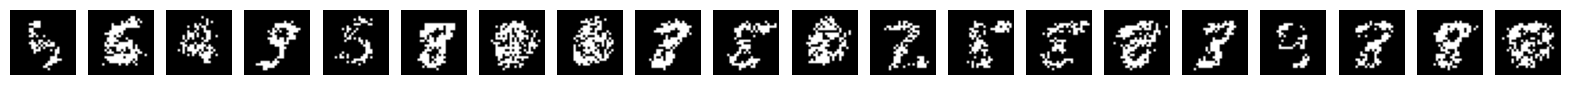

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Resto del código para definir la clase RBM y entrenarla

# Generar nuevas imágenes utilizando la RBM entrenada
num_images = 20  # Número de imágenes a generar

# Inicializar los nodos visibles con valores aleatorios o con datos reales
visible_states = np.random.rand(num_images, rbm.num_visible)

for _ in range(rbm.num_hidden):  # Iterar para estabilizar los estados ocultos
    hidden_probs, hidden_states = rbm.sample_hidden(visible_states)
    visible_probs, visible_states = rbm.sample_visible(hidden_states)

# Mostrar las imágenes generadas
fig, axs = plt.subplots(1, num_images, figsize=(20, 2))

for i in range(num_images):
    image = visible_states[i].reshape(28, 28)  # Redimensionar a 28x28
    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')

plt.show()
